<a href="https://colab.research.google.com/github/sadra-barikbin/persian-sentiment-analysis-example/blob/main/sentiment-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 dir='rtl'>
زبان‌پژوهان حرفه‌ای
</h1>

<h3 dir='rtl'>
صدرالدین باریک‌بین، سید محمد حسینی، امین بهجتی
</h3>

<div dir='rtl'>
در این تمرین، هدف یادگیری و دسته‌بندی متون آزمون بر اساس احساس موجود در آن‌هاست. دسته‌بندی باید با ۳ روش خطی، مبتنی بر شبکه عصبی و مبتنی بر مدل زبانی انجام شود؛ نتایج آن‌ها گزارش شود و برای هر کدام نیز مارکرهایی استخراج شود.
</div>

# Setup

<div dir='rtl'>
در این بخش پکیج‌ها و کتاب‌خانه‌های لازم را import می‌کنیم
</div>

In [1]:
!pip install clean-text[gpl] pytorch-ignite transformers

     |████████████████████████████████| 240 kB 12.9 MB/s 
     |████████████████████████████████| 3.4 MB 49.6 MB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
     |████████████████████████████████| 61 kB 464 kB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 895 kB 40.4 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 170 kB 49.7 MB/s 
     |████████████████████████████████| 235 kB 52.1 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=80b098b9108f0e66ae764fc010d4f1d796e926d8d1c84f6540ce4efe67b8a424
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=3aa11480f78c916f3dee56644daabecb6928078ecbe2e38b5d35aa1f19e8287a
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690

In [2]:
import numpy as np
import pandas as pd
from typing import Dict
import cleantext
from imblearn.over_sampling import RandomOverSampler

# Loading & Preparing Data

<div dir='rtl'>
ابتدا داده‌های یادگیری و ارزیابی را دانلود می‌کنیم
و پس از
load
کردن آن‌ها، شناسه‌شان را حذف می‌کنیم
و سپس
rate
آن‌ها را باینری می‌کنیم
</div>

In [3]:
!gdown 'https://drive.google.com/uc?id=1HH8QFDcvkKfnj4dWmFQceb3PpNqDD8HQ&authuser=0&export=download'
!gdown 'https://drive.google.com/uc?id=1uDOO8RP7Lr9qcRJO8z3d10qm_UggJv4I&authuser=0&export=download'

Downloading...
From: https://drive.google.com/uc?id=1HH8QFDcvkKfnj4dWmFQceb3PpNqDD8HQ&authuser=0&export=download
To: /content/train.csv
100% 171k/171k [00:00<00:00, 66.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uDOO8RP7Lr9qcRJO8z3d10qm_UggJv4I&authuser=0&export=download
To: /content/eval.csv
100% 43.5k/43.5k [00:00<00:00, 72.7MB/s]


In [4]:
train_df = pd.read_csv('train.csv')
eval_df = pd.read_csv('eval.csv')

In [5]:
train_df.head()

,Unnamed: 0,comment,rate
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هست...,0.0
1,22591,سلام به دوستای عزیزم \nعزاداری هاتون قبول باشه,1.0
2,141037,کلا پولتون رو دور نریزیزد,-1.0
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پو...,1.0
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراح...,1.0


In [ ]:
eval_df.head()

,Unnamed: 0,comment,rate
0,61591,کیفیت غذا و زمان رسیدن عالی بود,-1.0
1,50299,در‌ حد ساندویچ یه نفره بود نه دونفره یا بمب. ک...,1.0
2,2777,طعم پیتزای چهار فصل مثل همشه خیلی خوب بود اما ...,-1.0
3,9126,مشخصات سخت افزاری مناسب در کنار سیستم عامل وین...,0.5
4,7544,مرغش سوخاری و خوشمزه بود، بسته بندی عالی، قیمت...,-1.0


In [6]:
train_df = train_df.drop(train_df.columns[0], axis=1)
eval_df = eval_df.drop(eval_df.columns[0], axis=1)

In [7]:
print(f"{len(train_df[train_df.rate == 0])} out of {len(train_df)} train comments have rate zero.")
print(f"{len(eval_df[eval_df.rate == 0])} out of {len(eval_df)} eval comments have rate zero.")

104 out of 800 train comments have rate zero.
30 out of 200 eval comments have rate zero.


In [8]:
train_df = train_df[train_df.rate != 0]
eval_df  = eval_df[eval_df.rate != 0]

In [9]:
train_df['rate'] = train_df.rate.apply(lambda r: 1 if r > 0 else 0)
eval_df['rate'] = eval_df.rate.apply(lambda r: 1 if r > 0 else 0)

## Balancing Dataset

<div dir='rtl'>
همانطور که در زیر می‌بینید، داده‌ها متوازن نیستند. ما از استراتژی over-sampling روی دسته‌ی منفی استفاده می‌کنیم تا داده‌های balanced شوند.
</div>

In [10]:
pd.concat([train_df.rate.value_counts().rename('train'),
           eval_df.rate.value_counts().rename('eval')], axis=1)

,train,eval
1,502,115
0,194,55


In [11]:
balancer = RandomOverSampler(random_state=41)
train_df, _ = balancer.fit_resample(train_df, train_df.rate)
eval_df, _ = balancer.fit_resample(eval_df, eval_df.rate)

## Normalization

<div dir='rtl'>
در این بخش با استفاده از کتاب‌خانه cleantext داده‌ها را نرمال‌سازی می‌کنیم.
</div>

In [12]:
params = {'to_ascii':False, 'no_urls':True,    'no_phone_numbers':True, 'no_line_breaks':True,
          'no_emails':True, 'no_numbers':True, 'no_digits':True,        'no_currency_symbols':True}

train_df['comment'] = train_df.comment.apply(lambda c: cleantext.clean(c,**params))
eval_df['comment'] = eval_df.comment.apply(lambda c: cleantext.clean(c,**params))

## Vocabulary

<div dir='rtl'>
در این بخش از یک مجموعه داده استفاده می‌کنیم و آن را استفاده از دادگان یادگیری به روز می‌کنیم
</div>

In [ ]:
with open("vocab.txt") as fp:
    words = set([w.strip() for w in fp.readlines()])
len(words)

FileNotFoundError: ignored

In [ ]:
from nltk.tokenize import word_tokenize

for c in train_df['comment']:
    words.update(word_tokenize(c))

In [ ]:
vocab = sorted(words)

In [ ]:
with open('vocab.txt', 'w') as fw:
    for w in vocab:
        fw.write(w + '\n')

In [ ]:
len(vocab)

# Method 1: Linear Models

<div dir='rtl'>
در بخش دسته‌بندی خطی، ما از Tf-Idf برای تبدیل متون به بردار استفاده می‌کنیم
و سپس با استفاده از رگرسیون خطی و SVM دسته‌بندی را انجام می‌دهیم
</div>

## Import Statements

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

In [ ]:
vectorizer = TfidfVectorizer(max_features=600, ngram_range=(1,3))

In [ ]:
pipeline = Pipeline([('embedding', vectorizer),
                     ('classifier', LinearSVC())])
pipeline.fit(train_df.comment, train_df.rate)

Pipeline(steps=[('embedding',
                 TfidfVectorizer(max_features=600, ngram_range=(1, 3))),
                ('classifier', LinearSVC())])

## Hyper-parameter Tuning


<div dir='rtl'>
حال با استفاده از GridSearchCV
از بین تنظیمات مختلف برای Tf-Idf
و دسته‌بند مورد استفاده، بهترین تنظیمات را به دست می‌آوریم
</div>

In [ ]:
param_grid = {'embedding__ngram_range': [(1,2),(1,3),(1,4)],
              'embedding__max_features': range(100, 3000, 100),
              'classifier': [LinearSVC(),LogisticRegression()]}

In [ ]:
# The smelling code here is due to Scikit GridSearchCV's specific input for `cv` parameter.
# GridSearchCV and other meta-estimators in Scikit accept whole data (train+eval) in their `fit`
# method. So if you have a dataset separated in train and eval parts beforehand, you should
# concatenate them. Beside that you have to give indices of train and eval parts as the `cv` parameter.

train_eval = pd.concat((train_df, eval_df), ignore_index=True)
train_eval_indices = [(train_df.index, eval_df.index + len(train_df))]
meta_estimator = GridSearchCV(pipeline, param_grid, scoring=['accuracy', 'f1'],
                              cv=train_eval_indices, refit='f1', verbose=1)
_ = meta_estimator.fit(train_eval.comment, train_eval.rate)

Fitting 1 folds for each of 174 candidates, totalling 174 fits


In [ ]:
meta_estimator.best_params_

{'classifier': LinearSVC(),
 'embedding__max_features': 600,
 'embedding__ngram_range': (1, 3)}

<div dir='rtl'>
 دسته‌بند بهینه SVM است
</div>

In [ ]:
print(f"Best model F1: {meta_estimator.best_score_}")

Best model F1: 0.7063197026022304


## Determining Marker Features

<div dir='rtl'>
سپس بر اساس میزان تأثیرگذاری featureها
در دسته‌بندی، ده تای مهم آن را استخراج کرده و سپس کلمات مربوط به آن‌ها به عنوان مارکرها بازیابی می‌کنیم
</div>

In [ ]:
selector = SelectFromModel(pipeline, threshold=-np.inf, max_features=10, prefit=True,
                           importance_getter='named_steps.classifier.coef_')

pipeline['embedding'].get_feature_names_out()[selector.get_support()]

array(['ارسال', 'اینکه', 'لک', 'معمولی', 'من خیلی', 'میدان', 'نيست',
       'هم که', 'چندان', 'کاملا'], dtype=object)

# Method 2: Neural Networks

In [ ]:
import tensorflow as tf

In [ ]:
EMBED_DIM = 200
SEQ_LEN = 64
VOCAB_SIZE = len(vocab)
BATCH_SIZE = 20
CLASS_NO = 2

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['comment'], train_df['rate'])).shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
eval_ds = tf.data.Dataset.from_tensor_slices((eval_df['comment'], eval_df['rate'])).shuffle(buffer_size=len(eval_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import TextVectorization, Embedding, Input, Dense, Bidirectional, LSTM
from tensorflow.keras.models import Sequential

def create_lstm_model(lstm_dim=64, dense_dim=16):
    vectorizer = TextVectorization(vocabulary='vocab.txt',
                                   output_mode='int', 
                                   output_sequence_length=SEQ_LEN)
    return Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Embedding(VOCAB_SIZE + 4, EMBED_DIM, name='embedding'),
        Bidirectional(LSTM(lstm_dim)),
        Dense(dense_dim, activation='relu'),
        Dense(CLASS_NO, 'softmax')
    ])

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = create_lstm_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_m])

In [ ]:
len(model.layers[0].get_vocabulary())

60275

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 64)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 64, 200)           12055000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12,192,778
Trainable params: 12,192,778
No

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max')

In [ ]:
model.fit(train_ds, validation_data=eval_ds, epochs=10)

Epoch 1/10
51/51 [==============================] - 14s 207ms/step - loss: 0.6790 - accuracy: 0.5916 - f1_m: 0.6463 - val_loss: 0.6745 - val_accuracy: 0.6000 - val_f1_m: 0.6604
Epoch 2/10
51/51 [==============================] - 10s 195ms/step - loss: 0.3515 - accuracy: 0.8855 - f1_m: 0.6558 - val_loss: 0.9430 - val_accuracy: 0.6130 - val_f1_m: 0.6616
Epoch 3/10
51/51 [==============================] - 10s 191ms/step - loss: 0.0733 - accuracy: 0.9801 - f1_m: 0.6623 - val_loss: 1.2968 - val_accuracy: 0.6130 - val_f1_m: 0.6530
Epoch 4/10
51/51 [==============================] - 10s 189ms/step - loss: 0.0254 - accuracy: 0.9920 - f1_m: 0.6569 - val_loss: 1.3554 - val_accuracy: 0.6261 - val_f1_m: 0.6655
Epoch 5/10
51/51 [==============================] - 10s 193ms/step - loss: 0.0131 - accuracy: 0.9960 - f1_m: 0.6586 - val_loss: 1.8099 - val_accuracy: 0.6304 - val_f1_m: 0.6607
Epoch 6/10
51/51 [==============================] - 10s 193ms/step - loss: 0.0112 - accuracy: 0.9960 - f1_m: 0.6631

# Method 3: Pre-trained Language Models

## Import Statements

In [13]:
import torch
from ignite.engine  import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, Fbeta
from transformers   import BertModel, BertTokenizer
from torch import nn
from torch.optim    import AdamW
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers.models.bert.modeling_bert import BertEncoder

DEVICE = "cuda" if torch.cuda.is_available() else 'cpu'

## Prepare PyTorch Dataset & Data Loader

In [14]:
class SentimentDataset(Dataset):
  def __init__(self,data_frame: pd.DataFrame):
    self.data_frame = data_frame
  def __len__(self):
    return len(self.data_frame)
  def __getitem__(self,idx):
    item = self.data_frame.iloc[idx]
    return item.comment, item.rate


In [15]:
train_ds = SentimentDataset(train_df)
eval_ds = SentimentDataset(eval_df)

In [30]:
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-zwnj-base')
def tokenize_and_encode_collate(input):
  # `LongTensor` here matters. Otherwise it will raise error  in CUDA mode.
  targets = torch.LongTensor([sample[1] for sample in input])
  comments = tokenizer.batch_encode_plus([sample[0] for sample in input],
                                         return_tensors='pt', padding=True, truncation=True)
  return comments, targets

In [31]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,
                          collate_fn=tokenize_and_encode_collate)
eval_loader  = DataLoader(eval_ds, batch_size=16, shuffle=False,
                          collate_fn=tokenize_and_encode_collate)

## Define Model

In [57]:
class SentimentClassifier(nn.Module):
  def __init__(self):
    super(SentimentClassifier,self).__init__()
    self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-zwnj-base',
                                          output_attentions=False)
    self.cls = nn.ModuleList([nn.Linear(768,70), nn.ReLU(),
                              nn.Linear(70, 20), nn.ReLU(), nn.Linear(20,2)])
  def forward(self, input: Dict[str,torch.Tensor]) -> torch.Tensor:
    embedding = self.bert(**input).pooler_output
    immediate = embedding
    for layer in self.cls:
      immediate = layer(immediate)
    return immediate

In [58]:
model = SentimentClassifier().to(DEVICE)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

## Optimization Setup

In [59]:
optimizer_parameter_groups = [
  {'params': list(model.bert.parameters()),'lr': 1e-5},
  {'params': list(model.cls.parameters()), 'lr': 1e-3}
]
optimizer = torch.optim.AdamW(optimizer_parameter_groups)
criterion = nn.CrossEntropyLoss()

## Train & Evaluation

In [60]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=DEVICE)

val_metrics = {"accuracy": Accuracy(), "BCE": Loss(criterion), 'F1': Fbeta(1)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [61]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
  evaluator.run(eval_loader)
  metrics = evaluator.state.metrics
  avg_accuracy = metrics["accuracy"]
  avg_bce = metrics["BCE"]
  avg_f1 = metrics['F1']
  tqdm.write(
      f"Validation Results - Epoch: {engine.state.epoch} Avg accuracy: {avg_accuracy:.2f} Avg loss: {avg_bce:.2f} Avg F1: {avg_f1:.2f}"
  )

In [62]:
trainer.run(train_loader, max_epochs=20)



ITERATION - loss: 0.00:   0%|          | 0/1004 [40:51<?, ?it/s]

Validation Results - Epoch: 1 Avg accuracy: 0.71 Avg loss: 0.64 Avg F1: 0.70




ITERATION - loss: 0.00:   0%|          | 0/1004 [41:50<?, ?it/s]

Validation Results - Epoch: 2 Avg accuracy: 0.67 Avg loss: 1.03 Avg F1: 0.67




ITERATION - loss: 0.00:   0%|          | 0/1004 [42:49<?, ?it/s]

Validation Results - Epoch: 3 Avg accuracy: 0.64 Avg loss: 0.67 Avg F1: 0.63




ITERATION - loss: 0.00:   0%|          | 0/1004 [43:47<?, ?it/s]

Validation Results - Epoch: 4 Avg accuracy: 0.62 Avg loss: 0.95 Avg F1: 0.62




ITERATION - loss: 0.00:   0%|          | 0/1004 [44:46<?, ?it/s]

Validation Results - Epoch: 5 Avg accuracy: 0.68 Avg loss: 2.24 Avg F1: 0.67




ITERATION - loss: 0.00:   0%|          | 0/1004 [45:45<?, ?it/s]

Validation Results - Epoch: 6 Avg accuracy: 0.68 Avg loss: 3.24 Avg F1: 0.67




ITERATION - loss: 0.00:   0%|          | 0/1004 [46:44<?, ?it/s]

Validation Results - Epoch: 7 Avg accuracy: 0.65 Avg loss: 3.63 Avg F1: 0.64




ITERATION - loss: 0.00:   0%|          | 0/1004 [47:43<?, ?it/s]

Validation Results - Epoch: 8 Avg accuracy: 0.61 Avg loss: 3.77 Avg F1: 0.60




ITERATION - loss: 0.00:   0%|          | 0/1004 [48:42<?, ?it/s]

Validation Results - Epoch: 9 Avg accuracy: 0.67 Avg loss: 1.51 Avg F1: 0.67




ITERATION - loss: 0.00:   0%|          | 0/1004 [49:41<?, ?it/s]

Validation Results - Epoch: 10 Avg accuracy: 0.67 Avg loss: 0.82 Avg F1: 0.67




ITERATION - loss: 0.00:   0%|          | 0/1004 [50:40<?, ?it/s]

Validation Results - Epoch: 11 Avg accuracy: 0.63 Avg loss: 3.48 Avg F1: 0.59




ITERATION - loss: 0.00:   0%|          | 0/1004 [51:40<?, ?it/s]

Validation Results - Epoch: 12 Avg accuracy: 0.65 Avg loss: 2.49 Avg F1: 0.63




ITERATION - loss: 0.00:   0%|          | 0/1004 [52:39<?, ?it/s]

Validation Results - Epoch: 13 Avg accuracy: 0.66 Avg loss: 2.71 Avg F1: 0.65




ITERATION - loss: 0.00:   0%|          | 0/1004 [53:38<?, ?it/s]

Validation Results - Epoch: 14 Avg accuracy: 0.65 Avg loss: 3.44 Avg F1: 0.63




ITERATION - loss: 0.00:   0%|          | 0/1004 [54:37<?, ?it/s]

Validation Results - Epoch: 15 Avg accuracy: 0.65 Avg loss: 3.51 Avg F1: 0.63




ITERATION - loss: 0.00:   0%|          | 0/1004 [55:36<?, ?it/s]

Validation Results - Epoch: 16 Avg accuracy: 0.65 Avg loss: 3.84 Avg F1: 0.63




ITERATION - loss: 0.00:   0%|          | 0/1004 [56:34<?, ?it/s]

Validation Results - Epoch: 17 Avg accuracy: 0.65 Avg loss: 3.91 Avg F1: 0.62




ITERATION - loss: 0.00:   0%|          | 0/1004 [57:34<?, ?it/s]

Validation Results - Epoch: 18 Avg accuracy: 0.61 Avg loss: 1.69 Avg F1: 0.57




ITERATION - loss: 0.00:   0%|          | 0/1004 [58:32<?, ?it/s]

Validation Results - Epoch: 19 Avg accuracy: 0.64 Avg loss: 3.14 Avg F1: 0.61




ITERATION - loss: 0.00:   0%|          | 0/1004 [59:31<?, ?it/s]

Validation Results - Epoch: 20 Avg accuracy: 0.63 Avg loss: 2.87 Avg F1: 0.61


State:
	iteration: 20080
	epoch: 20
	epoch_length: 1004
	max_epochs: 20
	output: 2.145764938177308e-06
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [63]:
state = evaluator.run(eval_loader)

In [64]:
state.metrics

{'BCE': 2.8700107740319294,
 'F1': 0.6113242808008106,
 'accuracy': 0.6304347826086957}

In [65]:
state = trainer.run(train_loader)



ITERATION - loss: 0.00:   0%|          | 0/1004 [1:00:31<?, ?it/s]

Validation Results - Epoch: 1 Avg accuracy: 0.64 Avg loss: 2.95 Avg F1: 0.63


In [66]:
state.metrics

{}

# Final Evaluation

## Import Statements

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score
from ignite.metrics import ConfusionMatrix

## Test data preparation

<div dir='rtl'>
ابتدا فایل تست را دانلود می‌کنیم و آن را تبدیل به باینری می‌کنیم
</div>

In [ ]:
!gdown 'https://drive.google.com/uc?id=1nXjaHjsGDbaPyxQX5-y7D-hfgl6tcomC&authuser=0&export=download'

Downloading...
From: https://drive.google.com/uc?id=1nXjaHjsGDbaPyxQX5-y7D-hfgl6tcomC&authuser=0&export=download
To: /content/test.csv
100% 37.6k/37.6k [00:00<00:00, 62.5MB/s]


In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_df.head()

,Unnamed: 0,comment,rate
0,1980,IXY فقط زبان ژاپني انگليسي داره,0.0
1,55810,به نظر من کسی بدون شنیدن یه حرف نمیتونی در اون...,1.0
2,29718,تو وصف این داستان زیبا مثل های شیوای فارسی زیا...,1.0
3,48815,بسیارعالی برای خشکی پوست,1.0
4,6133,البته متاسفانه ابن قابلیت در مورد تمامی برنامه...,-0.5


In [ ]:
test_df = test_df.drop(test_df.columns[0], axis=1)

In [ ]:
print(f"{len(test_df[test_df.rate == 0])} out of {len(test_df)} test comments have rate zero.")

22 out of 170 test comments have rate zero.


In [ ]:
test_df = test_df[test_df.rate != 0]

In [ ]:
test_df['rate'] = test_df.rate.apply(lambda r: 1 if r > 0 else 0)

## Normalize Test data

<div dir='rtl'>
سپس داده‌های تست را نرمال‌سازی می‌کنیم
</div>

In [ ]:
params = {'to_ascii':False, 'no_urls':True,    'no_phone_numbers':True, 'no_line_breaks':True,
          'no_emails':True, 'no_numbers':True, 'no_digits':True,        'no_currency_symbols':True}

test_df['comment'] = test_df.comment.apply(lambda c: cleantext.clean(c,**params))

## Evaluate

<div dir='rtl'>
حال روی هر روش دسته‌بندی ارزیابی را انجام می‌دهیم و Confusion Matrix را نمایش می‌دهیم</div>

### Method 1

In [ ]:
predictions = pipeline.predict(test_df.comment)

In [ ]:
print(f'Accuracy : {accuracy_score(test_df.rate, predictions)}')
print(f'F1 score : {f1_score(test_df.rate, predictions)}')

Accuracy : 0.7094594594594594
F1 score : 0.7860696517412935


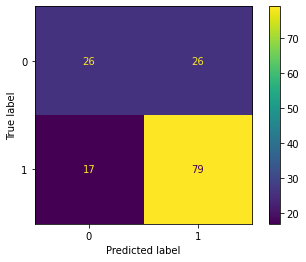

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_df.rate, predictions)

### Method 2

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df['comment'], test_df['rate'])).shuffle(buffer_size=len(test_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 54ms/step - loss: 1.2070 - accuracy: 0.7297 - f1_m: 0.7892


[1.2070480585098267, 0.7297297120094299, 0.7891807556152344]

In [ ]:
preds = model.predict(test_df.comment)

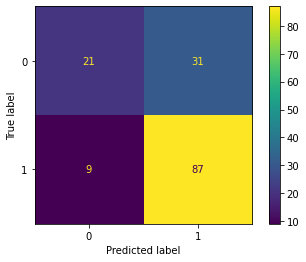

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_df.rate, np.argmax(preds, axis=1))

### Method 3

In [68]:
cm = ConfusionMatrix(num_classes=2, average='samples')
cm.attach(evaluator, 'cm')
state = evaluator.run(eval_loader)
print(state.metrics)

{'accuracy': 0.6434782608695652, 'BCE': 2.951250689962636, 'F1': 0.6286231884057967, 'cm': tensor([[0.2217, 0.2783],
        [0.0783, 0.4217]])}
